## Flowers Classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

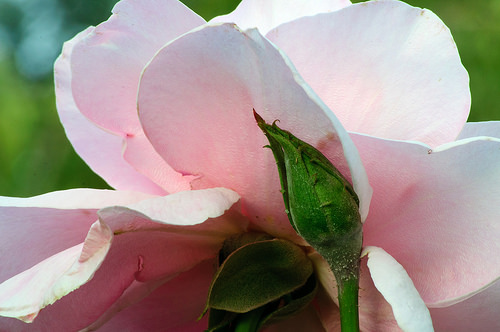

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

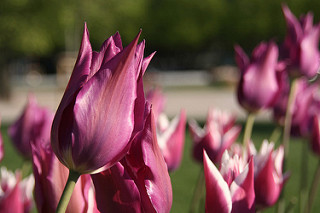

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                              validation_split = 0.2,
                                                              subset='training',
                                                              seed=20,
                                                              image_size=(img_width, img_height),
                                                              label_mode='int',
                                                              batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                            validation_split = 0.2,
                                                            subset='validation',
                                                            seed=20,
                                                            image_size=(img_width, img_height),
                                                            label_mode='int',
                                                            batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [12]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


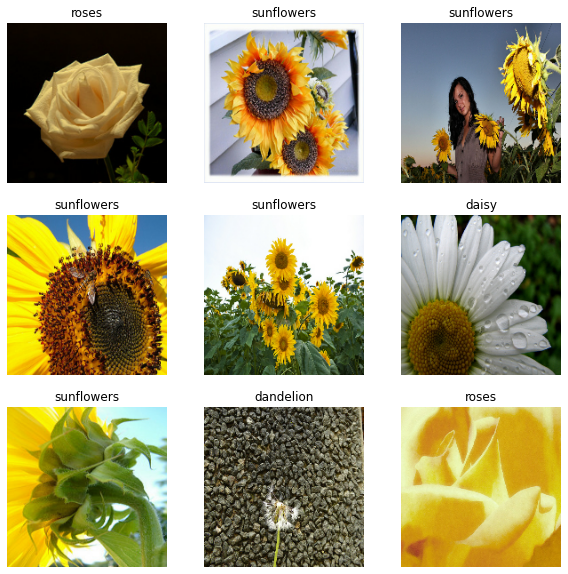

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
# dataset.cache() - keeps the images in memory after they're loaded off disk during the first epoch
# dataset.prefetch() - overlaps data preprocessing and model execution while training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
num_classes = 5

In [18]:
model = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [20]:
optimizer   = tf.keras.optimizers.Adam()
loss        = tf.keras.losses.SparseCategoricalCrossentropy()
metrics     = ['accuracy']

In [21]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [22]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [23]:
epochs = 30
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [24]:
history = model.fit(train_ds,
										validation_data = val_ds,
										epochs = epochs,
										callbacks = callbacks
										)

Epoch 1/30
92/92 [==============================] - 12s 60ms/step - loss: 1.3253 - accuracy: 0.4366 - val_loss: 1.1362 - val_accuracy: 0.5640
Epoch 2/30
92/92 [==============================] - 4s 41ms/step - loss: 1.0057 - accuracy: 0.6015 - val_loss: 1.0141 - val_accuracy: 0.6281
Epoch 3/30
92/92 [==============================] - 4s 41ms/step - loss: 0.8097 - accuracy: 0.6921 - val_loss: 0.9863 - val_accuracy: 0.6253
Epoch 4/30
92/92 [==============================] - 4s 41ms/step - loss: 0.5956 - accuracy: 0.7824 - val_loss: 0.9858 - val_accuracy: 0.6185
Epoch 5/30
92/92 [==============================] - 4s 41ms/step - loss: 0.3767 - accuracy: 0.8655 - val_loss: 1.0704 - val_accuracy: 0.6540
Epoch 6/30
92/92 [==============================] - 4s 41ms/step - loss: 0.2405 - accuracy: 0.9220 - val_loss: 1.2189 - val_accuracy: 0.6213
Epoch 7/30
92/92 [==============================] - 4s 41ms/step - loss: 0.1424 - accuracy: 0.9554 - val_loss: 1.3076 - val_accuracy: 0.6608
Epoch 8/30
9

<Figure size 432x288 with 0 Axes>

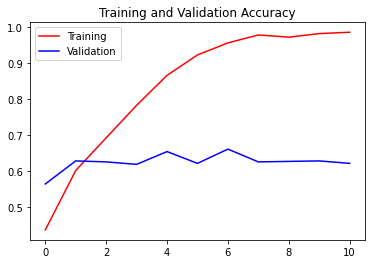

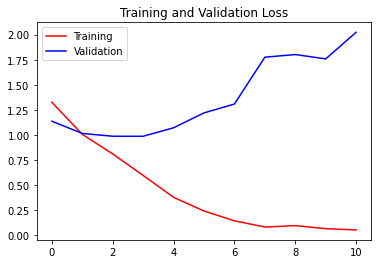

<Figure size 432x288 with 0 Axes>

In [25]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Tackle Overfitting

In [26]:
data_augmentation = Sequential([           
                  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                  layers.experimental.preprocessing.RandomRotation(0.1),
                  layers.experimental.preprocessing.RandomZoom(0.1)
])

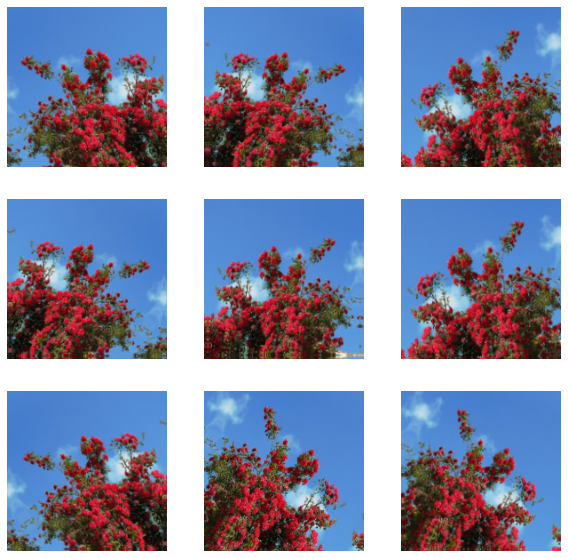

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [28]:
model = Sequential([
      data_augmentation,
      layers.experimental.preprocessing.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [30]:
optimizer   = tf.keras.optimizers.Adam()
loss        = tf.keras.losses.SparseCategoricalCrossentropy()
metrics     = ['accuracy']

In [31]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [32]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [33]:
epochs = 30
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [34]:
history = model.fit(train_ds,
										validation_data = val_ds,
										epochs = epochs,
										callbacks = callbacks
										)

Epoch 1/30
92/92 [==============================] - 6s 51ms/step - loss: 1.3256 - accuracy: 0.4322 - val_loss: 1.1585 - val_accuracy: 0.5368
Epoch 2/30
92/92 [==============================] - 4s 48ms/step - loss: 1.0762 - accuracy: 0.5644 - val_loss: 1.2197 - val_accuracy: 0.5586
Epoch 3/30
92/92 [==============================] - 4s 48ms/step - loss: 0.9827 - accuracy: 0.6117 - val_loss: 1.0588 - val_accuracy: 0.5926
Epoch 4/30
92/92 [==============================] - 4s 48ms/step - loss: 0.8926 - accuracy: 0.6492 - val_loss: 1.0830 - val_accuracy: 0.6090
Epoch 5/30
92/92 [==============================] - 4s 48ms/step - loss: 0.8328 - accuracy: 0.6751 - val_loss: 0.9939 - val_accuracy: 0.6294
Epoch 6/30
92/92 [==============================] - 4s 48ms/step - loss: 0.7735 - accuracy: 0.6952 - val_loss: 0.8858 - val_accuracy: 0.6649
Epoch 7/30
92/92 [==============================] - 4s 48ms/step - loss: 0.7515 - accuracy: 0.7061 - val_loss: 0.8846 - val_accuracy: 0.6444
Epoch 8/30
92

<Figure size 432x288 with 0 Axes>

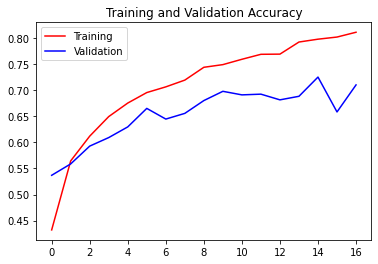

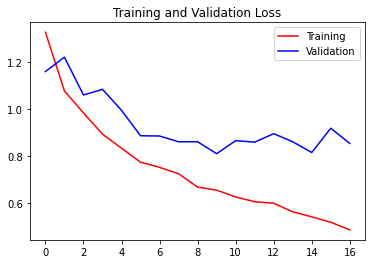

<Figure size 432x288 with 0 Axes>

In [35]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()